<a href="https://www.kaggle.com/code/sheemamasood/birdclef2025-psedolabelling-for-ssl?scriptVersionId=245931639" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# Standard Libraries
import os
import gc
import time
import math
import random
import warnings
import logging
from pathlib import Path
from glob import glob
from typing import Union
import copy
import concurrent.futures

# Data Handling
import numpy as np
import pandas as pd
import joblib
import pickle
import collections
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report

# Audio Processing
import librosa
import librosa.display
import soundfile as sf
from soundfile import SoundFile
import torchaudio

# Machine Learning & PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.cuda.amp import autocast, GradScaler
import timm

# Visualization
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

# Progress Bars
from tqdm import tqdm
from tqdm.notebook import tqdm as notebook_tqdm

# Logging and Warnings
warnings.filterwarnings("ignore")
logging.basicConfig(level=logging.ERROR)

# Check versions
print(f"librosa version : {librosa.__version__}")
print(f"librosa files : {librosa.__file__}")
print("✅ All libraries imported in the environment.")


librosa version : 0.11.0
librosa files : /usr/local/lib/python3.11/dist-packages/librosa/__init__.py
✅ All libraries imported in the environment.


In [2]:

class Config:
    # ===== General Settings =====
    seed = 42
    print_freq = 100
    num_workers = 4

    # ===== Audio Settings =====
    FS = 32000  # Sampling rate
    N_FFT = 1024
    HOP_LENGTH = 512
    FMIN = 50
    FMAX = 14000
    N_MELS = 128
    TARGET_DURATION = 10.0  # duration in seconds for full input
    TARGET_DURATION_TRAIN = 10
    TARGET_DURATION_TEST = 5

    # ===== Image / Mel Spectrogram Settings =====
    MEL_SHAPE = (3, 256, 256)         # (height, width)
    TARGET_SHAPE = (3, 256, 256)   # RGB Image Shape (C, H, W)

    # ===== Training Settings =====
    TRAINING_MODE = True
    EPOCHS = 10
    BATCH_SIZE = 32
    LEARNING_RATE = 0.001
    N_MAX = None  # Use full dataset by default

    # ===== File Paths =====
    train_datadir = '/kaggle/input/birdclef-2025/train_audio'
    train_csv = '/kaggle/input/birdclef-2025/train.csv'
    test_soundscapes = '/kaggle/input/birdclef-2025/test_soundscapes'
    submission_csv = '/kaggle/input/birdclef-2025/sample_submission.csv'
    taxonomy_csv = '/kaggle/input/birdclef-2025/taxonomy.csv'
    model_files = ['/kaggle/input/bird2025-sed-ckpt/sedmodel.pth']
    master_label_list_path = '/kaggle/input/birdcleft-clean-and-vad-filtered-data/valid_labels.pkl'

    # ===== Model Settings =====
    model_name = 'seresnext26t_32x4d'
    pretrained = False
    in_channels = 1

    # ===== Derived Attributes (initialized later) =====
    master_labels = None
    NUM_CLASSES = None

    @classmethod
    def init_labels(cls):
        with open(cls.master_label_list_path, "rb") as f:
            cls.master_labels = pickle.load(f)
        cls.NUM_CLASSES = len(cls.master_labels)


# Instantiate and initialize
config = Config()
config.init_labels()

print(f"✅ Loaded master label list. Total number of classes: {config.NUM_CLASSES}")


✅ Loaded master label list. Total number of classes: 187


In [3]:
# Load the master label list and set NUM_CLASSES
with open("/kaggle/input/birdcleft-clean-and-vad-filtered-data/master_label_list.pkl", "rb") as f:
    master_labels = pickle.load(f)
NUM_CLASSES = len(master_labels)  # should be 206


print(f"total number of labels in full data : {len(master_labels)}")  

total number of labels in full data : 206


In [4]:
def set_seed(seed=42):
    """
    Set seed for reproducibility
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(config.seed)


## ImprovedBirdCLEFModel

In [5]:
class ImprovedBirdCLEFModel(nn.Module):
    def __init__(self, num_classes=206, pretrained=True):
        super().__init__()
        
        self.backbone = timm.create_model(
            "seresnext26t_32x4d",  # ⬅️ hf_hub hata diya downloaded weights use kry gy
            pretrained=False,  
            in_chans=3,
            num_classes=0
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(self.backbone.num_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.backbone(x)             # Already [B, 2048]
        #print("After backbone:", x.shape)
        x = self.classifier(x)           # [B, num_classes]
        return x


def freeze_backbone(model):
    for param in model.backbone.parameters():
        param.requires_grad = False

def unfreeze_last_blocks(model, num_blocks=2):
    # Unfreezes last few blocks of the backbone
    children = list(model.backbone.children())
    for block in children[-num_blocks:]:
        for param in block.parameters():
            param.requires_grad = True

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ImprovedBirdCLEFModel(num_classes=206)
state_dict = torch.load('/kaggle/input/birdcleft-clean-and-vad-filtered-data/best_model_phase1.pth', map_location=device)
model.load_state_dict(state_dict)
model.to(device)
model.eval()


ImprovedBirdCLEFModel(
  (backbone): ResNet(
    (conv1): Sequential(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track

## Phase 2 (continue training):

In [7]:
# Your paths
mel_dir = "/kaggle/input/birdclef-2025-mel-spectrogram"
soundscape_csv_path = "/kaggle/input/birdcleft-clean-and-vad-filtered-data/clean_soundscapes_chunks_10sec_vad_filtered.csv"

# Read soundscape CSV
soundscape_df = pd.read_csv(soundscape_csv_path)
print("✅ Soundscape CSV loaded:", soundscape_df.shape)

# Clean chunk_id for key matching (replace '/' with '-')
soundscape_df['chunk_id_clean'] = soundscape_df['chunk_id'].str.replace('/', '-', regex=False)

# Filter soundscape mel batch files
clean_soundscape_files = sorted([
    f for f in os.listdir(mel_dir)
    if f.startswith("clean_soundscape") and f.endswith(".npz")
])
print(f"🟢 Found {len(clean_soundscape_files)} clean_soundscape .npz files")

# Build key-to-file index for clean_soundscape
key_to_file_soundscape = {}

print("🔍 Indexing clean_soundscape mel keys...")
for batch_file in tqdm(clean_soundscape_files):
    path = os.path.join(mel_dir, batch_file)
    try:
        npz = np.load(path)
        for key in npz.files:
            key_to_file_soundscape[key] = batch_file
    except Exception as e:
        print(f"⚠️ Error reading {batch_file}: {e}")

print(f"✅ Total keys indexed: {len(key_to_file_soundscape)}")

# Optional check: How many chunk_ids from df are present in the index?
available_keys = soundscape_df['chunk_id_clean'].isin(key_to_file_soundscape)
print(f"🧩 Matched chunks in index: {available_keys.sum()} / {len(soundscape_df)}")


✅ Soundscape CSV loaded: (21854, 9)
🟢 Found 22 clean_soundscape .npz files
🔍 Indexing clean_soundscape mel keys...


100%|██████████| 22/22 [00:00<00:00, 34.56it/s]

✅ Total keys indexed: 21854
🧩 Matched chunks in index: 21854 / 21854


In [8]:
class BirdMelNPZDatasetSSL(Dataset):
    def __init__(self, df, mel_dir, key_to_file, labels=None, augment=False, sample_rate=32000):
        self.df = df.reset_index(drop=True)
        self.mel_dir = mel_dir
        self.key_to_file = key_to_file
        self.augment = augment
        self.sample_rate = sample_rate

        # Optional labels argument to maintain structure
        self.labels = labels

        self.df['chunk_id_clean'] = self.df['chunk_id'].str.replace('/', '-', regex=False)
        self.loaded_batches = {}

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        key = row['chunk_id_clean']
    
        batch_file = self.key_to_file.get(key, None)
        if batch_file is None:
            mel = np.zeros((3, 256, 256), dtype=np.float32)
        else:
            if batch_file not in self.loaded_batches:
                path = os.path.join(self.mel_dir, batch_file)
                self.loaded_batches[batch_file] = np.load(path)
    
            mel = self.loaded_batches[batch_file][key]
    
        if self.augment:
            mel = self.apply_augmentation(mel)
    
        mel_tensor = torch.tensor(mel, dtype=torch.float32)
        return mel_tensor, key  # <-- Return tuple (tensor, key)

    
    def apply_augmentation(self, mel):
        mel = self.time_mask(mel, T=30)
        mel = self.freq_mask(mel, F=15)
        mel = self.add_noise(mel, noise_level=0.01)
        return mel

    def time_mask(self, mel, T=30):
        t = mel.shape[2]
        t0 = np.random.randint(0, max(1, t - T))
        mel[:, :, t0:t0 + T] = 0
        return mel

    def freq_mask(self, mel, F=15):
        f = mel.shape[1]
        f0 = np.random.randint(0, max(1, f - F))
        mel[:, f0:f0 + F, :] = 0
        return mel

    def add_noise(self, mel, noise_level=0.01):
        noise = np.random.randn(*mel.shape) * noise_level
        return mel + noise

def ssl_collate_fn(batch):
    mels = torch.stack([item[0] for item in batch])  # stack tensors into batch
    keys = [item[1] for item in batch]              # keep keys as list
    return mels, keys


In [9]:
ssl_dataset = BirdMelNPZDatasetSSL(df=soundscape_df, mel_dir=mel_dir, key_to_file=key_to_file_soundscape, augment=True)

ssl_loader = DataLoader(
    ssl_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=0,
    collate_fn=ssl_collate_fn
)



def check_ssl_dataset(dataset, name="SSL Dataset"):
    print(f"\n=== {name.upper()} SAMPLE CHECK ===")
    
    mel_tensor, key = dataset[0]  # unpack tuple
    print("Type:", type(mel_tensor))
    print("Shape:", mel_tensor.shape)
    print("Dtype:", mel_tensor.dtype)
    print("Key (chunk id):", key)


check_ssl_dataset(ssl_dataset, "SSL Dataset")


ssl_batch, ssl_keys = next(iter(ssl_loader))

print("=== SSL BATCH ===")
print("Type:", type(ssl_batch))         # <class 'torch.Tensor'>
print("Batch shape:", ssl_batch.shape)  # (32, 3, 256, 256)
print("Keys type:", type(ssl_keys))     # <class 'list'>
print("Number of keys:", len(ssl_keys)) # 32





=== SSL DATASET SAMPLE CHECK ===
Type: <class 'torch.Tensor'>
Shape: torch.Size([3, 256, 256])
Dtype: torch.float32
Key (chunk id): H27_20230421_155000_chunk0
=== SSL BATCH ===
Type: <class 'torch.Tensor'>
Batch shape: torch.Size([32, 3, 256, 256])
Keys type: <class 'list'>
Number of keys: 32


SSL Dataset Samples:


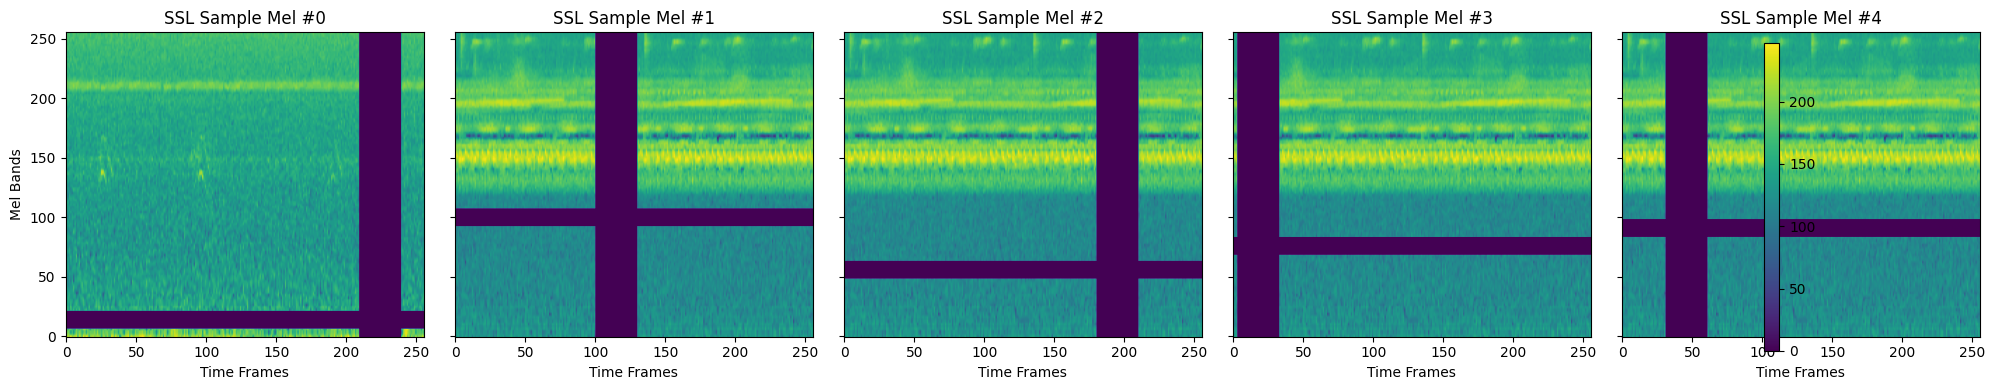

In [10]:
def plot_multiple_mels_ssl(dataset, indices, title_prefix='SSL Sample Mel Spectrogram'):
    n = len(indices)
    fig, axes = plt.subplots(1, n, figsize=(4*n, 4))  # 1 row, n columns

    for i, idx in enumerate(indices):
        item = dataset[idx]
        # If item is tuple, get first element, else item itself
        mel_tensor = item[0] if isinstance(item, tuple) else item
        mel = mel_tensor[0, :, :].numpy()  # first channel (2D matrix)

        ax = axes[i] if n > 1 else axes
        im = ax.imshow(mel, aspect='auto', origin='lower')
        ax.set_title(f"{title_prefix} #{idx}")
        ax.set_xlabel("Time Frames")
        ax.set_ylabel("Mel Bands")
        ax.label_outer()  # only show outer labels for clean look

    fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
    plt.tight_layout()
    plt.show()


print("SSL Dataset Samples:")
plot_multiple_mels_ssl(ssl_dataset, indices=list(range(5)), title_prefix='SSL Sample Mel')


In [11]:
from tqdm import tqdm
import numpy as np
import torch

def generate_pseudo_labels(
    model, dataloader, device, threshold=0.7, return_filtered=True
):
    """
    Generate pseudo-labels from model predictions on unlabeled soundscape data.
    
    Args:
        model: Trained PyTorch model (should output logits).
        dataloader: DataLoader for soundscape data, should return (inputs, file_ids).
        device: torch.device ('cuda' or 'cpu').
        threshold: float, probability threshold to binarize predictions.
        return_filtered: bool, if True, only return confident samples.
    
    Returns:
        filenames: list of filenames of samples (filtered if return_filtered=True).
        pseudo_labels: numpy array of pseudo-labels (binary).
    """
    model.eval()
    all_probs = []
    all_filenames = []
    
    with torch.no_grad():
        for inputs, file_ids in tqdm(dataloader, desc="Pseudo-labeling Soundscapes"):
            inputs = inputs.to(device)
            outputs = model(inputs)  # logits
            probs = torch.sigmoid(outputs).cpu().numpy()  # convert to probabilities
            
            all_probs.append(probs)
            all_filenames.extend(file_ids)
    
    all_probs = np.vstack(all_probs)
    
    # Binarize predictions by threshold
    pseudo_labels = (all_probs >= threshold).astype(int)
    
    if return_filtered:
        # Filter samples where max probability exceeds threshold (confident predictions only)
        confident_indices = [i for i, p in enumerate(all_probs) if p.max() > threshold]
        
        filtered_filenames = [all_filenames[i] for i in confident_indices]
        filtered_pseudo_labels = pseudo_labels[confident_indices]
        
        return filtered_filenames, filtered_pseudo_labels
    
    return all_filenames, pseudo_labels


In [12]:
import pickle

# Load master label list
with open("/kaggle/input/birdcleft-clean-and-vad-filtered-data/master_label_list.pkl", "rb") as f:
    class_names = pickle.load(f)

print(f"Loaded {len(class_names)} class names.")


Loaded 206 class names.


In [13]:
# Assume generate_pseudo_labels returns (chunk_ids, pseudo_labels)
chunk_ids, pseudo_labels = generate_pseudo_labels(
    model, ssl_loader, device, threshold=0.7
)

print(f"Generated pseudo-labels for {len(chunk_ids)} confident samples.")

# Create DataFrame with chunk_id as key
df = pd.DataFrame(pseudo_labels, columns=class_names)  # class_names = list of your classes
df['chunk_id'] = chunk_ids

# Save with chunk_id column for easy merging later
df.to_csv("pseudo_labels_soundscape.csv", index=False)


Pseudo-labeling Soundscapes: 100%|██████████| 683/683 [05:01<00:00,  2.27it/s]

Generated pseudo-labels for 1684 confident samples.


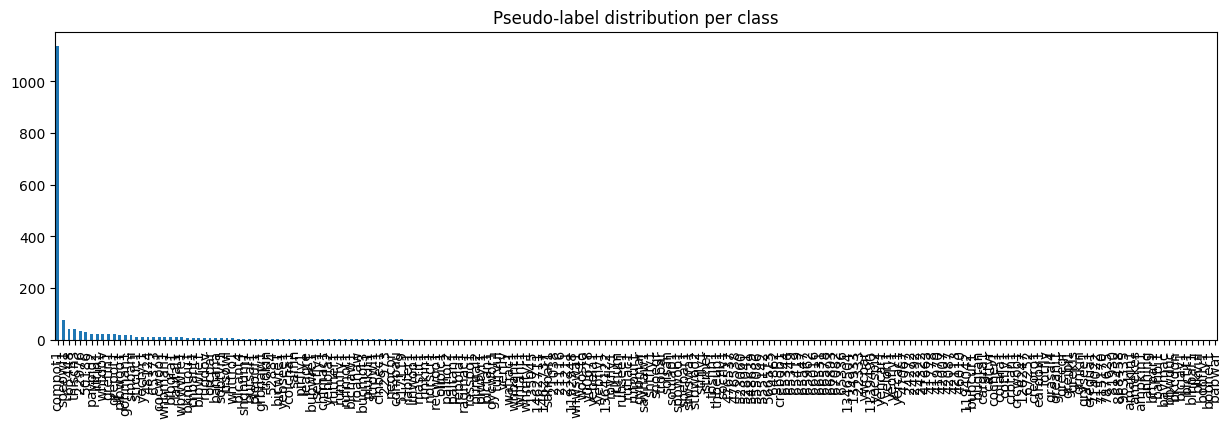

In [14]:
# sanity check like label distribution

label_counts = df[class_names].sum().sort_values(ascending=False)
label_counts.plot(kind='bar', figsize=(15, 4))
plt.title("Pseudo-label distribution per class")
plt.xticks(rotation=90)
plt.show()


In [15]:
label_counts

compot1    1136
speowl1      75
65448        42
thlsch3      41
22976        32
           ... 
blhpar1       0
blkvul        0
bobfly1       0
bobher1       0
babwar        0
Length: 206, dtype: int64

In [16]:
import pandas as pd

pseudo_df = pd.read_csv("pseudo_labels_soundscape.csv")
print(f"Loaded {len(pseudo_df)} pseudo-labeled samples.")


Loaded 1684 pseudo-labeled samples.
